# Восстановление золота из руды

Нам необходимо подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Для работы используем данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, будет обращаться к библиотекам *pandas*, *matplotlib* и *sklearn.*

## Подготовка данных

Сначала загрузим необходимые библиотеки.

In [197]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import median
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


###  Изучение данных 

Создадим датасеты с тренировочными данными, тестовыми данными и полными данными.

In [198]:
full_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv')
test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv')
full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv')

Посмотрим на размеры датасетов. 

In [199]:
print(f'Полный датасет: {full.shape}')
print(f'Тренировочный датасет: {full_train.shape}')
print(f'Тестовый датасет: {test.shape}')

Полный датасет: (19439, 87)
Тренировочный датасет: (14149, 87)
Тестовый датасет: (5290, 53)


Видно, что полный датасет представляет собой все данные. Тренировочный - часть данных. Тестовый - оставшуюся часть данных, но с удаленными столбцами.

Посмотрим на колонки в полном датасете.

In [200]:
full.columns

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

Согласно документации, названия колонок означают следующее:
1. Первый блок - этап:
    - rougher — флотация
    - primary_cleaner — первичная очистка
    - secondary_cleaner — вторичная очистка
    - final — финальные характеристики
2. Второй блок - тип параметра:
    - input — параметры сырья
    - output — параметры продукта
    - state — параметры, характеризующие текущее состояние этапа
    - calculation — расчётные характеристики
3. Третий же блок - название параметра.

### Проверка расчета эффективности обогащения

На первом этапе заказчик попросил проверить правильность расчета эффективности обогащения после этапа флотации. Для этого воспользуемся предоставленной заказчиком формулой, которая включает в себя долю золота в сырье до флотации, в концентрате после флотации и в хвосте после флотации.

In [201]:
R_C, R_F, R_T = (full_train['rougher.output.concentrate_au'], 
                 full_train['rougher.input.feed_au'], 
                 full_train['rougher.output.tail_au'])

rougher_recovery = (((R_C * (R_F - R_T) / (R_F * (R_C - R_T))) * 100).to_frame().
                    set_axis(['recovery_calculated'], axis=1, inplace=False))

Теперь посчитаем значение средней абсолютной ошибки для рассчитанного и представленного в таблице значения эффективности и выведем его на экран.

In [202]:
rougher_recovery['recovery_experimental'] = full_train['rougher.output.recovery']
rougher_MAE = (sum(abs(rougher_recovery['recovery_experimental'] - rougher_recovery['recovery_calculated']) / 
       len(rougher_recovery['recovery_experimental'])))
print(f'Значение MAE составляет {rougher_MAE:.2e}')

Значение MAE составляет 9.68e-15


Видно, что значение ошибки очень мало, поэтому можно сделать вывод о том, что эффективность была посчитана верна.

### Каких признаков нет в тестовой выборке?

Как было отмечено выше, в тестовой выборке не хватает некоторых столбцов. Посмотрим, что это за столбцы.

In [203]:
not_in_test = [x for x in full_train.columns if x not in test.columns]
not_in_test

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

Видно, что в тестовой выборке отсутствуют значения, которые характеризуют продукты флотации и процессы, происходящие после неё.

Для последующей проверки полученной модели на тестовой выборке нам нужно, чтобы в тренировочной были те же столбцы, что и в тестовой. Поэтому удалим из тренировочного датасета лишние столбцы.

In [204]:
train = full_train.drop(not_in_test, axis=1)

Проверим размеры наших датасетов.

In [205]:
print(f'Тренировочный датасет: {train.shape}')
print(f'Тестовый датасет: {test.shape}')

Тренировочный датасет: (14149, 53)
Тестовый датасет: (5290, 53)


Видно, что количество столбцов теперь совпадает.

### Предобработка

Посмотрим на количество отсутствующих значений в столбцах.

In [206]:
train.isna().sum().sort_values(ascending=False)

rougher.state.floatbank10_e_air               436
rougher.input.floatbank11_xanthate            428
secondary_cleaner.state.floatbank2_a_air      217
rougher.input.feed_size                       144
primary_cleaner.input.xanthate                100
rougher.input.feed_pb                         100
rougher.input.feed_sol                         78
rougher.input.floatbank11_sulfate              36
primary_cleaner.input.depressant               32
rougher.input.floatbank10_sulfate              29
secondary_cleaner.state.floatbank2_b_air       21
primary_cleaner.input.sulfate                  20
rougher.input.floatbank10_xanthate              8
rougher.input.feed_rate                         8
secondary_cleaner.state.floatbank4_a_air        6
primary_cleaner.state.floatbank8_b_air          4
secondary_cleaner.state.floatbank3_a_air        4
primary_cleaner.state.floatbank8_a_air          4
primary_cleaner.state.floatbank8_d_air          3
primary_cleaner.state.floatbank8_c_air          2


Так как наши данные представляют собой параметры, измеряемые каждый час, предлагается заменить пропущенные данные на те, которые следуют после них.

In [207]:
train.fillna(method='ffill', inplace=True)

Посмотрим еще раз на отсутствующие данные.

In [208]:
train.isna().sum().sort_values(ascending=False)

secondary_cleaner.state.floatbank6_a_level    0
rougher.state.floatbank10_b_air               0
rougher.state.floatbank10_a_air               0
rougher.input.floatbank11_xanthate            0
rougher.input.floatbank11_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.input.floatbank10_sulfate             0
rougher.input.feed_au                         0
rougher.input.feed_sol                        0
rougher.input.feed_size                       0
rougher.input.feed_rate                       0
rougher.input.feed_pb                         0
rougher.input.feed_ag                         0
primary_cleaner.state.floatbank8_d_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_a_air  

Видно, что пропуски отсутствуют.

**Вывод:**

В данном пункте было сделано следующее:
1. Проведено первичное знакомство с данными.
2. Рассчитаны параметры эффективности флотации и сравнены со значениями, представленными в датасете. MAE оказалась очень мала, что говорит о том, что расчеты были проведены верно.
3. Определено, что в тестовой выборке отсутствуют некоторые признаки, поэтому эти признаки были удалены из тренировочной выборки.
4. Проведена предобработка данных, в ходе которой отсутствующие данные были заменены на следующие после них.

## Анализ данных

### Как меняется концентрация металлов

Согласно заданию заказчика, на втором этапе работы сначала нам необходимо посмотреть, как меняется концентрация металлов на различных этапах очистки.

Для этого мы будем использовать полный датасет, пропуски в котором заменим тем же методом, что и в тренировочном датасете.

In [209]:
full.fillna(method='ffill', inplace=True)

#### Флотация

##### Перед флотацией

Построим гистограмму распределения концентраций металлов в сырье до флотации.

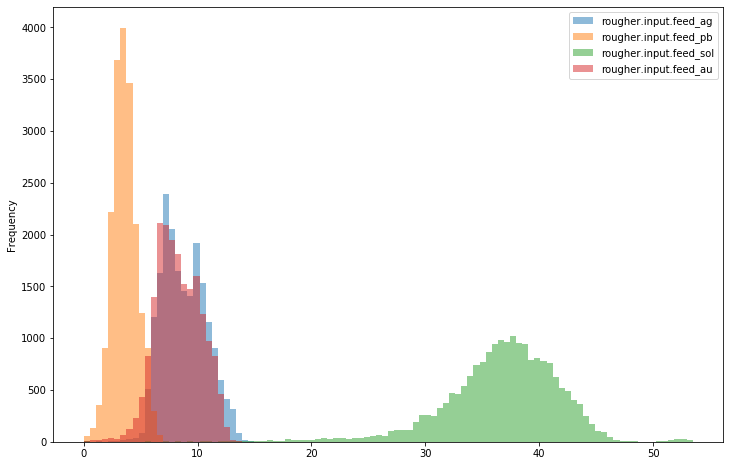

In [210]:
rougher_input = (full.loc[:, full.columns.str.contains('rougher.input.feed')].
                 drop(['rougher.input.feed_rate', 'rougher.input.feed_size'], axis=1))
rougher_input.plot(kind='hist', figsize=(12, 8), alpha=0.5, bins=100)

Видно, что в основном сырье состоят из золи. Содержание серебра и золота в сырье примерно одинаково. Меньше всего в сырье свинца.

##### Хвосты после флотации

Теперь посмотрим на распределение элементов после флотации. Начнем с хвостов.

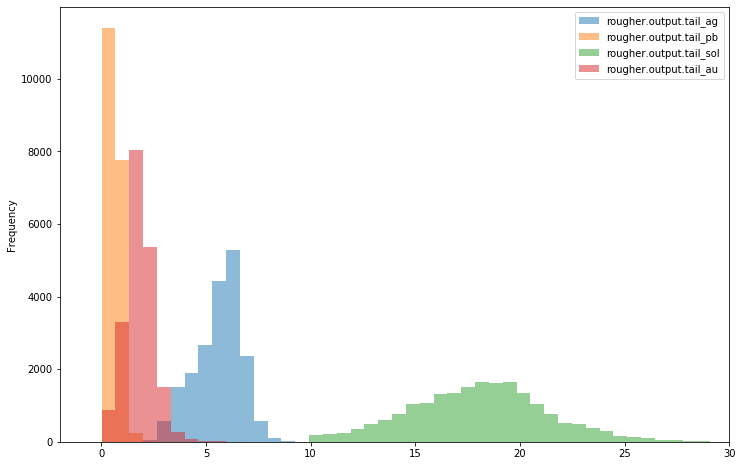

In [211]:
rougher_tail = (full.loc[:, full.columns.str.contains('rougher.output.tail')])
rougher_tail.plot(kind='hist', figsize=(12, 8), alpha=0.5, bins=100, xlim=(-2, 30))

Видно, что в хвостах после флотации также содержится в основном золь. При этом хвосты стали более обогащены серебром, далее по содержанию идет золото и свинец.

##### Концентрат после флотации

Посмотрим на концентрат после флотации.

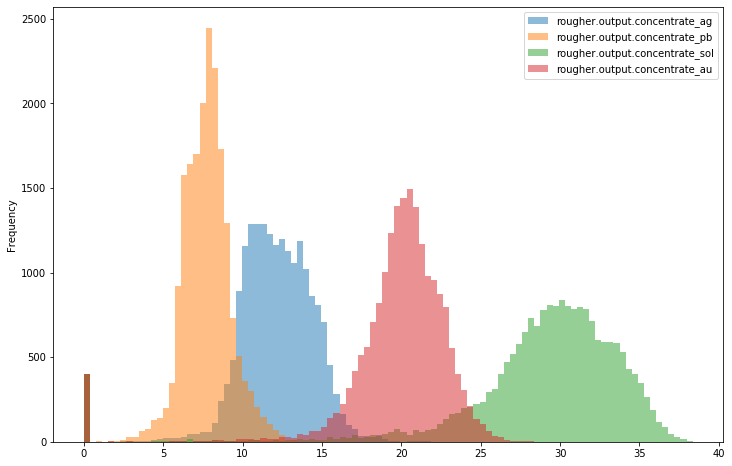

In [212]:
rougher_concentrate = (full.loc[:, full.columns.str.contains('rougher.output.concentrate')])
rougher_concentrate.plot(kind='hist',figsize=(12, 8), alpha=0.5, bins=100)

В данном случае видно, что хоть наш концентрат и содержит опять в основном золь, но содержание золота в нем теперь больше, чем свинца и серебра.

#### Первичная очистка

##### Хвосты после первичной очистки

Посмотрим на содержание элементов в хвостах после первичной очистки.

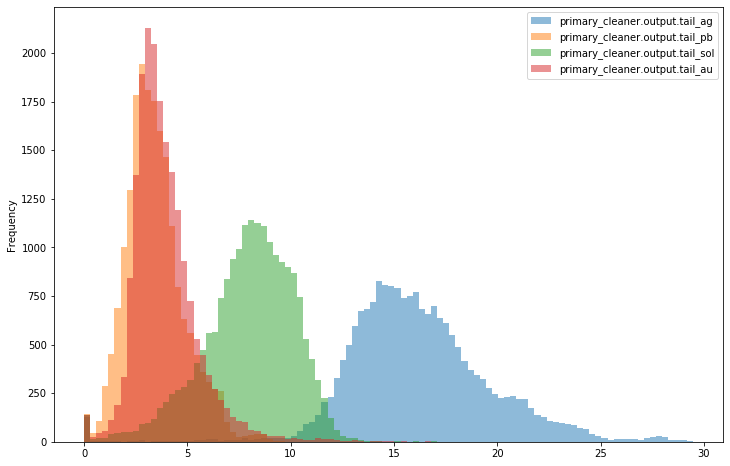

In [213]:
primary_tail = (full.loc[:, full.columns.str.contains('primary_cleaner.output.tail')])
primary_tail.plot(kind='hist', figsize=(12, 8), alpha=0.5, bins=100)

Видно, что после первичной очистки в хвостах остается в основном серебро и золь. Меньше всего в них содержится золота и свинца.

##### Концентрат первичной очистки

Оценим состав концентрата после первичной очистки.

In [214]:
full_train.columns

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

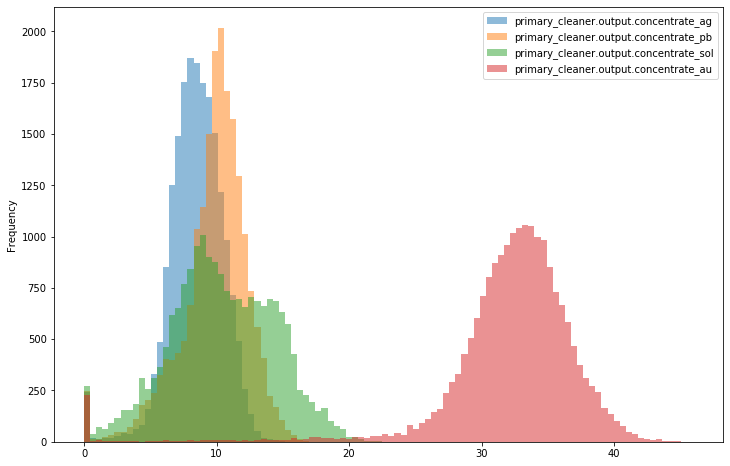

In [215]:
primary_concentrate = (full.loc[:, full.columns.str.contains('primary_cleaner.output.concentrate')])
primary_concentrate.plot(kind='hist', figsize=(12, 8), alpha=0.5, bins=100)

Видно, что теперь в образцах преобладает золото. Концентрации золи, серебра и свинца стали примерно одинаковы.

#### Вторичная очистка

##### Хвосты после вторичной очистки

Наконец, оценим концентрацию веществ в хвостах после вторичной очистки.

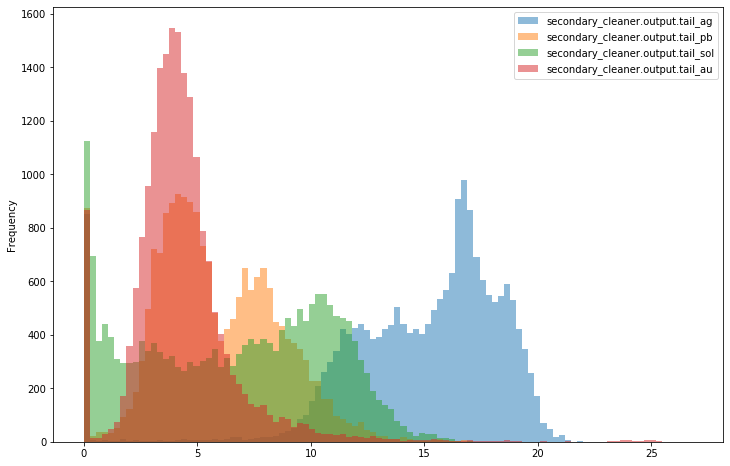

In [216]:
secondary_tail = (full.loc[:, full.columns.str.contains('secondary_cleaner.output')])
secondary_tail.plot(kind='hist', figsize=(12, 8), alpha=0.5, bins=100)

Видно, что в хвостах теперь распределения концентраций серебра и золи стали менее "нормальными", так как разные концентрации в них стали встречаться с примерно одинаковой частотой.

##### Концентрат после вторичной очистки

Согласно схеме очистки золотосодержащей руды, финальным концентратом является концентрат после вторичной очистки. Посмотрим на распределение веществ в нем.

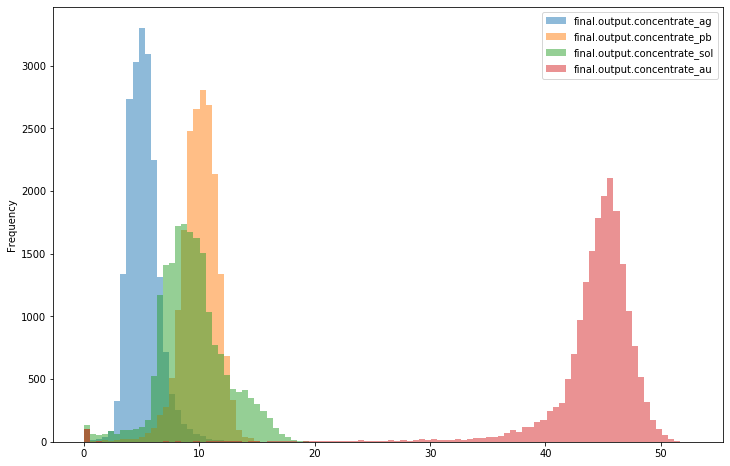

In [217]:
final_concentrate = (full.loc[:, full.columns.str.contains('final.output.concentrate')])
final_concentrate.plot(kind='hist', figsize=(12, 8), alpha=0.5, bins=100)

Видно, что теперь в концентрате сильно преобладает золото. Далее по содержанию идет золь и свинец, на последнем месте - серебро.

##### Финальные хвосты

Под финальными хвостами, по всей видимости, подразумевается смесь хвостов после флотации, а также первичной и вторичной очисток. Посмотрим на распределения.

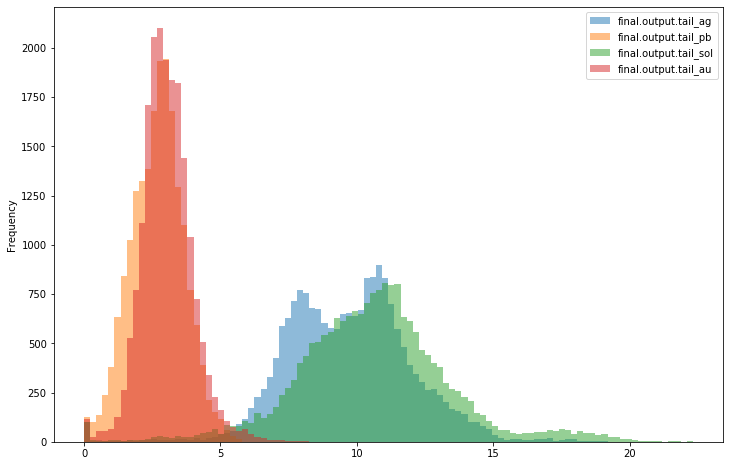

In [218]:
final_tail = (full.loc[:, full.columns.str.contains('final.output.tail')])
final_tail.plot(kind='hist', figsize=(12, 8), alpha=0.5, bins=100)

Действительно, финальные концентраты в основном состоят из золи и серебра.

### Сравниваем размеры гранул

На втором этапе нам необходимо сравнить размеры гранул в тренировочной и тестовой выборках. Необходимо убедиться, что распределения в данном случае одинаковы.

#### Перед флотацией

(-2, 150)

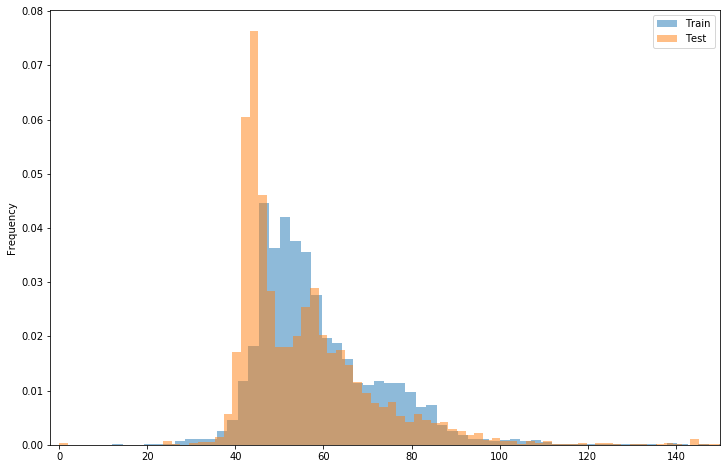

In [219]:
fig, ax = plt.subplots()
full_train['rougher.input.feed_size'].plot(kind='hist', ax=ax, density=True,
                                           figsize=(12, 8), alpha=0.5, bins=200, label='Train', legend=True)
test['rougher.input.feed_size'].plot(kind='hist', ax=ax, density=True,
                                     figsize=(12, 8), alpha=0.5, bins=200, label='Test', legend=True)
ax.set_xlim([-2, 150])

Видно, что распределения в данном случае немного различаются. В тренировочной выборке распределение является более нормальным, при этом в тестовой похоже на бимодальное.

Посчитаем числовые характеристики распределений.

In [220]:
pd.concat([test['rougher.input.feed_size'], full_train['rougher.input.feed_size']], axis=1).describe()

,rougher.input.feed_size,rougher.input.feed_size
count,5289.000000,14005.000000
mean,55.951097,60.110518
std,19.081758,22.418485
min,0.046369,9.659576
25%,43.906347,48.973027
50%,50.841029,55.373885
75%,62.431047,66.080172
max,392.494040,484.967466


Итак, видно, что:
- Причиной бимодальности распределения значений тестовой выборки может быть меньшее количество наблюдений в ней в 3 раза по сравнению с тренировочной.
- Среднее и медиана для выборок различаются не сильно и лежат в области 50.8 - 60.1 (скорее всего мм).

#### Перед очисткой

Посмотрим на распределения размеров частиц для обоих выборок перед очисткой.

(2, 14)

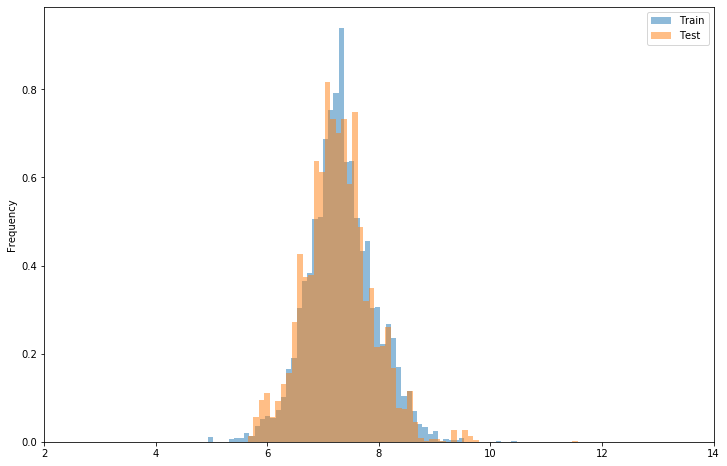

In [221]:
fig, ax = plt.subplots()
full_train['primary_cleaner.input.feed_size'].plot(kind='hist', ax=ax, density=True, 
                                                   figsize=(12, 8), alpha=0.5, bins=100, label='Train', legend=True)
test['primary_cleaner.input.feed_size'].plot(kind='hist', ax=ax, density=True, 
                                             figsize=(12, 8), alpha=0.5, bins=100, label='Test', legend=True)
ax.set_xlim([2, 14])

Видно, что в данном случае распределения близки друг к другу.

Также посчитаем числовые характеристики распределений.

In [222]:
pd.concat([test['primary_cleaner.input.feed_size'], full_train['primary_cleaner.input.feed_size']], axis=1).describe()

,primary_cleaner.input.feed_size,primary_cleaner.input.feed_size
count,5290.000000,14149.000000
mean,7.266339,7.322310
std,0.610219,0.614062
min,5.650000,1.080000
25%,6.890000,6.960000
50%,7.250000,7.290000
75%,7.600000,7.700000
max,15.500000,10.470000


Также видно, что частицы стали меньше по сравнению с размерами перед флотацией. Среднее и медиана для обоих выборок лежат в диапазоне 7.2 - 7.3 (также скорее всего мм).

### Посчитаем концентрации металлов на разных стадиях и построим гистограмму

Теперь посчитаем общие концентрации веществ в сырье перед флотацией и концентратах.

In [223]:
concentrations_sum = {}

concentrations_sum['rougher_input'] = rougher_input.sum(axis=1)
concentrations_sum['rougher_concentrate'] = rougher_concentrate.sum(axis=1)
concentrations_sum['final_concentrate'] = final_concentrate.sum(axis=1)

concentrations_sum = pd.DataFrame(concentrations_sum)

Посмотрим на распределения.

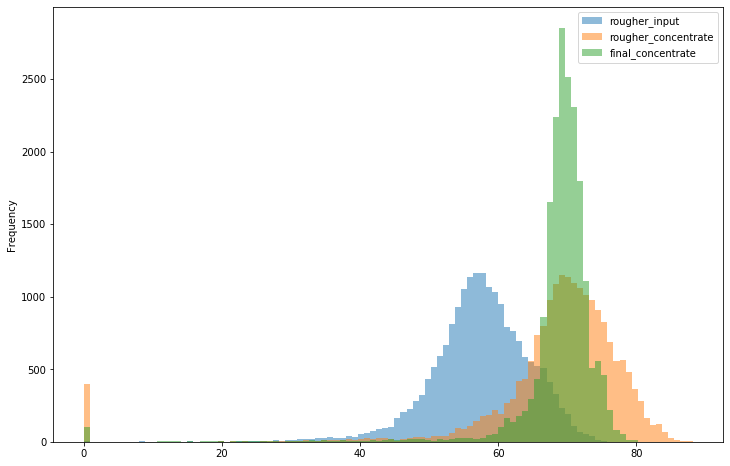

In [224]:
concentrations_sum.plot(kind='hist', figsize=(12, 8), bins=100, alpha=0.5)

По полученным гистограммам видно, что:
1. В сырье также присутствуют и другие элементы, так как суммарная концентрация не равна 100.
2. Общая концентрация веществ в сырье перед флотацией меньше всего и имеет достаточно широкое распределение. 
3. После флотации распределение концентраций в образцах также остается широким, но общая концентрация веществ растет. 
4. В финальном концентрате распределение концентраций веществ становится становится более узким.

Однако, в распределениях наблюдаются нулевые суммарные концентрации. Это может привести к проблемам в предсказании моделей. От этих строк лучше избавиться.

Посмотрим, в каких этапах очистки наблюдается такая проблема.

In [225]:
concentrations_sum.describe()

,rougher_input,rougher_concentrate,final_concentrate
count,19439.000000,19439.000000,19439.000000
mean,57.320789,68.170865,68.653624
std,7.212680,12.491279,7.427536
min,0.040000,0.000000,0.000000
25%,53.557679,66.012495,67.932362
50%,57.594391,70.181495,69.598444
75%,61.953459,74.356904,71.368472
max,76.978947,88.140119,80.210644


Видно, что это наблюдается в концентратах после флотации и финальных концентратах. 

Однако, в наших тренировочной и тестовой выборках есть только концентрации веществ в сырье перед флотацией. Столбцов с концентрациями элементов после флотации и финальной очистки нет.

Поэтому из них можно ничего не удалять.

**Выводы:**

В данном пункте было сделано следующее:
1. Проведено исследование того, как меняются концентрации веществ на разных этапах очистки.
2. Сравнены размеры гранул перед флотацией и перед очисткой в тестовой и тренировочной выборках. Сами распределения хоть немного и различатся, но их средние и медианы близки.
3. Посчитаны общие концентрации веществ на разных этапах очистки.

## Модель

Теперь нам необходимо построить модели, которые бы предсказывали эффективность обогащения чернового и финального концентратов.

### Функция для sMAPE

Напишем функцию, которая рассчитывает метрику качества sMAPE.

Используем полученную функцию для создания новой метрики качества модели.

In [226]:
def smape(target, predict):
    smape = sum((abs(predict - target)) / ((abs(predict) + abs(target)) / 2)) / len(target)
    return smape

smape_scorer = make_scorer(smape)

### Эффективность обогащения чернового концентрата

Построим модель для предсказывания эффективности чернового концентрата.

В этом случае нам необходимо использовать параметры, которые известны только на этом этапе. Так как на этапе флотации нам неизвестны параметры, например, вторичной очистки. Поэтому из тренировочных данных мы удалим все параметры, которые не относятся к этапу флотации.

In [227]:
X_r = pd.concat([train['date'], train.loc[:, train.columns.str.contains('rougher')]], axis=1).set_index('date')
Y_r = full.set_index('date').loc[X_r.index, 'rougher.output.recovery'].values

Так как нам необходимо предсказывать числовые значения на основе других числовых значений, логичнее всего использовать модель линейной регрессии с кросс-валидацией.

In [228]:
model_r = LinearRegression()
model_r.fit(X_r, Y_r)
cross_val_r = cross_val_score(model_r, X_r, Y_r, cv=10, scoring=smape_scorer)
smape_r = cross_val_r.mean()

Посчитаем среднюю метрику sMAPE для кросс-валидации.

In [229]:
print(f'sMAPE для модели предсказания эффективности чернового концентрата составляет {smape_r*100:.2f} %')

sMAPE для модели предсказания эффективности чернового концентрата составляет 11.06 %


### Эффективность обогащения финального концентрата

Построим модель для предсказывания эффективности чернового концентрата.

В этом случае можно использовать все параметры, которые присутствуют в выборке.

In [230]:
X_f = train.set_index('date')
Y_f = full.set_index('date').loc[X_f.index, 'final.output.recovery'].values

Также построим модель линейной регрессии с кросс-валидацией.

In [231]:
model_f = LinearRegression()
model_f.fit(X_f, Y_f)
cross_val_f = cross_val_score(model_f, X_f, Y_f, cv=10, scoring=smape_scorer)
smape_f = cross_val_f.mean()

Посчитаем среднюю метрику sMAPE для кросс-валидации.

In [232]:
print(f'sMAPE для модели предсказания эффективности финального концентрата составляет {smape_f*100:.2f} %')

sMAPE для модели предсказания эффективности финального концентрата составляет 11.57 %


### Итоговое sMAPE на тестовой выборке

Заполним пропуски в тестовой выборке так же, как мы это делали для других выборок.

In [233]:
test.fillna(method='ffill', inplace=True)

###### Эффективность обогащения чернового концентрата

Сначала проверим предсказание эффективности обогащения чернового концентрата. 

Удалим лишние столбцы из тестовой выборки для этой модели.

In [234]:
test_X_r = pd.concat([test['date'], test.loc[:, test.columns.str.contains('rougher')]], axis=1).set_index('date')
test_Y_r = full.set_index('date').loc[test_X_r.index, 'rougher.output.recovery'].values

Посчитаем sMAPE на тестовой выборке.

In [235]:
test_smape_r = smape(test_Y_r, model_r.predict(test_X_r))
print(f'sMAPE для модели предсказания эффективности чернового концентрата составляет {test_smape_r*100:.2f} %')

sMAPE для модели предсказания эффективности чернового концентрата составляет 9.32 %


Чтобы сравнить адекватность полученной метрики, попробуем посчитать sMAPE, предсказав везде медианные значения целевого признака.

In [236]:
smape_median_r = smape(test_Y_r, pd.Series([median(test_Y_r)]*len(test_Y_r)))
print(f'sMAPE для для модели медианных предсказаний составляет {smape_median_r*100:.2f} %')

sMAPE для для модели медианных предсказаний составляет 8.06 %


###### Эффективность обогащения финального концентрата

В данном случае опять же будем использовать все переменные.

In [237]:
test_X_f = test.set_index('date')
test_Y_f = full.set_index('date').loc[test_X_f.index, 'final.output.recovery'].values

In [238]:
test_smape_f = smape(test_Y_f, model_f.predict(test_X_f))
print(f'sMAPE для модели предсказания эффективности финального концентрата составляет {test_smape_f*100:.2f} %')

sMAPE для модели предсказания эффективности финального концентрата составляет 10.04 %


Чтобы сравнить адекватность полученной метрики, попробуем посчитать sMAPE, предсказав везде медианные значения целевого признака.

In [239]:
smape_median_f = smape(test_Y_f, pd.Series([median(test_Y_f)]*len(test_Y_f)))
print(f'sMAPE для для модели медианных предсказаний составляет {smape_median_f*100:.2f} %')

sMAPE для для модели медианных предсказаний составляет 9.17 %


###### Итоговое sMAPE

Посчитаем итоговое sMAPE

In [240]:
total_smape = 0.25*test_smape_r + 0.75*test_smape_f
print(f'Итоговое sMAPE для моделей составляет {total_smape*100:.2f} %')

Итоговое sMAPE для моделей составляет 9.86 %


In [241]:
total_smape_median = 0.25*smape_median_r + 0.75*smape_median_f
print(f'Итоговое sMAPE для медианной модели составляет {total_smape_median*100:.2f} %')

Итоговое sMAPE для медианной модели составляет 8.89 %


Видно, что в данном случае итоговое sMAPE для модели, которая просто предсказывает медиану, оказалось даже ниже, чем значение для созданной модели линейной регрессии.

### Сравнение предсказаний и реальных значений для обоих моделей

Представим графически предсказанные моделями и реальные значения целевого признака.

#### Предсказание эффективности чернового концентрата

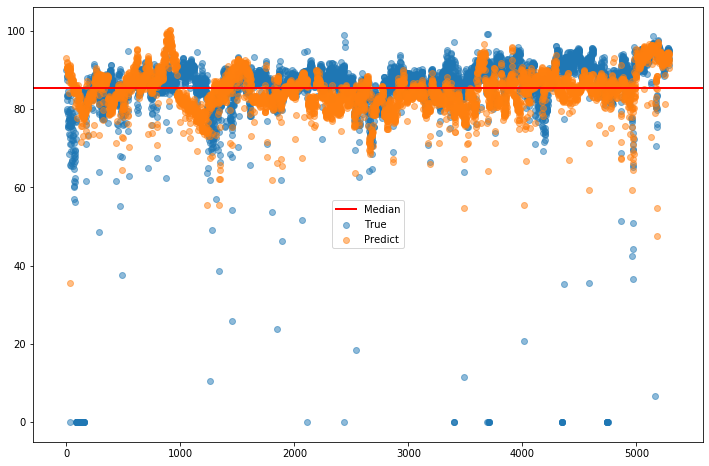

In [242]:
pred_r = model_r.predict(test_X_r)
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x=range(len(test_Y_r)), y=test_Y_r, label='True', alpha=0.5)
ax.scatter(x=range(len(pred_r)), y=pred_r, label='Predict', alpha=0.5)
ax.axhline(median(pd.Series(Y_r)), linewidth=2, color='r', label='Median')
ax.legend()

#### Предсказание эффективности финального концентрата

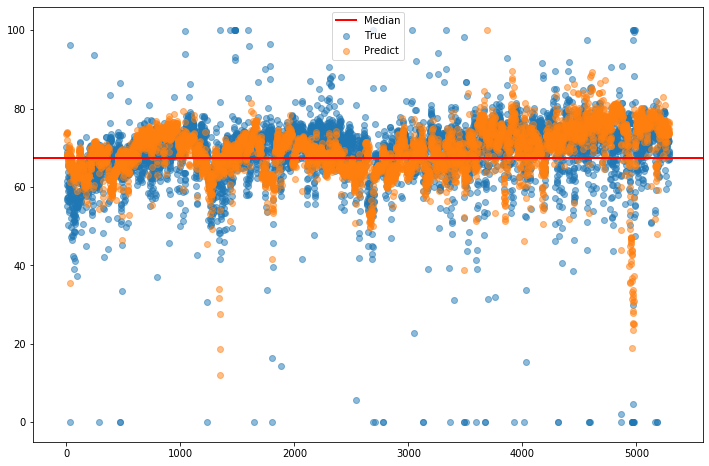

In [243]:
pred_f = model_f.predict(test_X_f)
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x=range(len(test_Y_f)), y=test_Y_f, label='True', alpha=0.5)
ax.scatter(x=range(len(pred_f)), y=pred_f, label='Predict', alpha=0.5)
ax.axhline(median(pd.Series(Y_f)), linewidth=2, color='r', label='Median')
ax.legend()

Видно, что несмотря на более низкое значение метрики sMAPE, наша модель улавливает больше особенностей распределения целевого признака, нежели модель с медианой.

**Вывод:**

В данном пункте было сделано следующее:
1. Создана новая метрика для оценки качества модели - sMAPE.
2. Построены модели для предсказания эффективности обогащения чернового концентрата и финального концентрата.
3. Посчитано итоговое sMAPE на тестовой выборке.
4. Построены графики распределений значений, предсказанных моделями и реальных значений признаков.

## Общий вывод

Задачей данной работы было построение модели, которая бы предсказывала эффективность обогащения золотосодержащей руды на этапах флотации и очистки.

В результате выполнения работы было сделано и выявлено следующее:
1. На первом этапе:
    - Были изучены исходные данные. 
    - Проверены рассчеты эффективности обогащения. 
    - Определены параметры, которые отсутствуют в тестовой выборке, которые были затем удалены из тренировочной выборки.
    - Проведена предобработка данных, в ходе которой пропуски были заменены на значения, следующие после них.
    
2. На втором этапе:
    - Проведено исследование того, как меняются концентрации веществ на разных этапах очистки.
    - Сравнены размеры гранул перед флотацией и перед очисткой в тестовой и тренировочной выборках. Сами распределения хоть немного и различатся, но их средние и медианы близки и составляют порядка 50 - 60 (предположительно мм) для гранул перед флотацией и 7 (предположительно мм) для гранул перед очисткой.
    - Посчитаны общие концентрации веществ на разных этапах очистки. Было показано, что помимо представленных в датасетах веществ, в сырье также присутствуют другие элементы, так как общие концентрации не равны 100 %.
   
3. На третьев этапе:
    - Создана новая метрика для оценки качества модели - sMAPE.
    - Построены модели линейной регрессии для предсказания эффективности обогащения чернового концентрата и финального концентрата.
    - Посчитано итоговое sMAPE на тестовой выборке, которое составило 9.32 %. Стоит отметить, что значение для модели, которая предсказывает просто медианное значение признака, составило даже меньше чем для созданной модели линейной регрессии.
    - Построены графики распределений значений, предсказанных моделями и реальных значений признаков. На графиках видно, что в целом модели позволяют достаточно хорошо предсказывать эффективности обогащения.
    - Посчитаны среднее абсолютные отклонения для обоих моделей, которое составило 6.18 и 6.12 для моделей предсказания эффективности обогащения чернового и финального концентратов, соответственно.